In this notebook I will try to force a first order phase transition in the EOS and MR curve. First order phase transitions are characterized by a jump in density while the pressure remains constant. Because the speed of sound is defined by

$$ c_s^2 = \frac{\partial P}{\partial \epsilon} $$

and the energy density is directly related to the density, we can force the phase transition by setting the speed of sound to zero. This means I can use the stepping method used for extending the EOS in other codes.

In [1]:
# import the libraries I need

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.interpolate
import test_TOVsolver

In [50]:
EOS_small = pd.read_table('../data/EOSCEFTVE1.dat', header=None).to_numpy()

n = EOS_small[:,0]
p = EOS_small[:,1]
e = EOS_small[:,2]

In [3]:
# we need to create an EOS with an unstable branch

def extend_Plin(ns, starts, cs2, n_step=None, size=None):
    """
    Function to extend the EOS with linear segments in pressure by using constant segments in speed of sound

    Inputs:
    n_step: int defining step size in density
    ns: array containing the densities where segments begin/end
    starts: array containing the starting values for the EOS (density, pressure, energy)
    cs2: array ocontaining randomly sampled speed of sound values

    Outputs:
    EOS_ex: array of shape (size, 3) containing the values for EOS extension
    """

    if size == None:
        size = int((ns[-1] - starts[0]) / n_step)
    elif type(size) == int:
        n_step = (ns[-1] - starts[0]) / size
    else:
        print("Please enter a value for `rho_step` or `size`")
        return

    # initialize array
    EOS_ex = np.zeros((size, 3))
    # set starting values at n = 2n0
    EOS_ex[0, 0] = starts[0]
    EOS_ex[0, 1] = starts[1]
    EOS_ex[0, 2] = starts[2]

    i = 0

    for k in range(size - 1):
        # n_i+1
        EOS_ex[k + 1, 0] = EOS_ex[k, 0] + n_step
        # p_i+1
        if ns[i] <= EOS_ex[k, 0] < ns[i + 1]:
            EOS_ex[k + 1, 1] = EOS_ex[k, 1] + n_step * cs2[i] * ((EOS_ex[k, 1] + EOS_ex[k, 2]) / EOS_ex[k, 0])
        else:
            i += 1
            EOS_ex[k + 1, 1] = EOS_ex[k, 1] + n_step * cs2[i] * ((EOS_ex[k, 1] + EOS_ex[k, 2]) / EOS_ex[k, 0])
        # e_i+1
        EOS_ex[k + 1, 2] = EOS_ex[k, 2] + n_step * ((EOS_ex[k, 1] + EOS_ex[k, 2]) / EOS_ex[k, 0])

    return EOS_ex

In [101]:
# now we define our density points and the speeds of sound
n0 = 0.16 #MeV/fm^3
ns = n0*np.linspace(2,14,20)

# derivative of pressure wrt energy
dp_de = scipy.interpolate.CubicSpline(p, e).derivative(nu=1)
# definition of speed of sound
cs2_start = 1 / dp_de(p[-1])
print(cs2_start)

# define small non-zero value for speed of sound segments
epsilon = 1e-3
cs2 = np.ones(ns.shape[0]-1)

begin_index = 5
end_index = 15

for i in range(cs2.shape[0]):
    if i < begin_index:
        cs2[i] = cs2_start
    
    elif begin_index <= i <= end_index:
        cs2[i] = epsilon

starts = [n[-1], p[-1], e[-1]]

0.13352290140997072


In [102]:
size = int(1e3)
EOS_ex = extend_Plin(ns, starts, cs2, size=size)

In [103]:
def stitch_EOS(small_EOS, EOS_ex):
    """
    Function to stitch EOS extension to original EOS

    Inputs:
    small_EOS: array containing original EOS
    EOS_ex: array containing EOS extension

    Outputs:
    tot_EOS: array containing total EOS
    """
    # get relevant sizes
    size_smol = small_EOS.shape[0] - 1  # -1 becuase we don't want last duplicated entry
    size_ex = EOS_ex.shape[0]

    # initialize array
    tot_EOS = np.zeros((size_smol + size_ex, small_EOS.shape[1]))

    tot_EOS[:size_smol, :] = small_EOS[:size_smol, :]
    tot_EOS[size_smol:, 0] = EOS_ex[:, 0]
    tot_EOS[size_smol:, 1] = EOS_ex[:, 1]
    tot_EOS[size_smol:, 2] = EOS_ex[:, 2]

    return tot_EOS

def dif_eos(EOS_table):
    dif_eos = np.zeros((EOS_table.shape[0]-1,EOS_table.shape[1]))
    
    for i in range(dif_eos.shape[0]):
        dif_eos[i,0] = EOS_table[i+1,0]
        dif_eos[i,1] = EOS_table[i+1,1] - EOS_table[i,1]
        dif_eos[i,2] = EOS_table[i+1,2] - EOS_table[i,2]
        
    return dif_eos

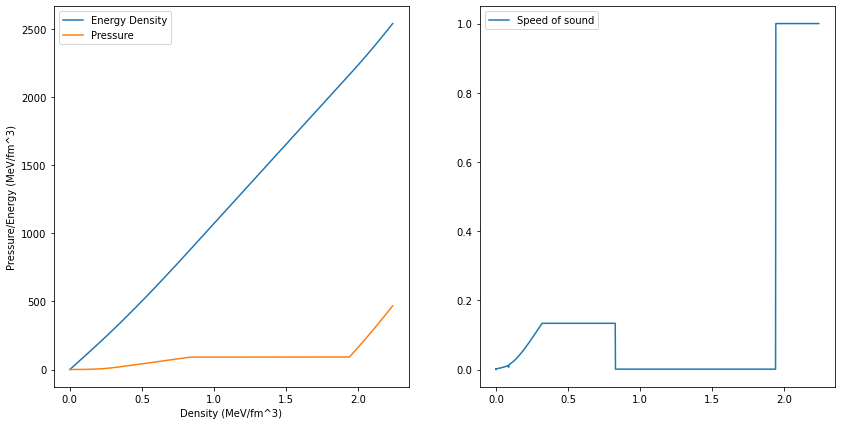

In [104]:
EOS_tot = stitch_EOS(EOS_small, EOS_ex)

difference_eos = dif_eos(EOS_tot)

fig, ax = plt.subplots(1,2, figsize=(14,7))

ax[0].plot(EOS_tot[:,0], EOS_tot[:,2], label="Energy Density")
ax[0].plot(EOS_tot[:,0], EOS_tot[:,1], label="Pressure")
ax[0].set_xlabel("Density (MeV/fm^3)")
ax[0].set_ylabel("Pressure/Energy (MeV/fm^3)")
ax[0].legend()

ax[1].plot(difference_eos[:,0], difference_eos[:,1]/difference_eos[:,2], label="Speed of sound")
ax[1].legend()

In [105]:
def strictly_increasing(array):
    
    size = len(array)
    # initialize values
    del_a = np.zeros(size-1)
    strctly_up = False
    
    for i in range(size-1):
        if array[i+1] > array[i]:
            del_a[i] = 1
        else:
            del_a[i] = 0
    if sum(del_a) == size-1:
        strctly_up = True
    
    return strctly_up

In [106]:
p_tot = EOS_tot[:,1]
increasing = strictly_increasing(p_tot)

increasing

True

In [107]:
MRL_curve = test_TOVsolver.solve(EOS_tot, max_pressure=1350)

C:\Users\brend\OneDrive\LANL Project\LANL_project\test_stuff\test_TOVsolver.py:76: RuntimeWarning: invalid value encountered in sqrt
  num0 = -2 * y[0] * (np.sqrt(y[0]) - 2 * y[1])
C:\Users\brend\OneDrive\LANL Project\LANL_project\test_stuff\test_TOVsolver.py:77: RuntimeWarning: invalid value encountered in power
  den0 = (EOS_e(p) + p) * (y[1] + 4 * pi * p * y[0] ** (3 / 2))
C:\Users\brend\OneDrive\LANL Project\LANL_project\test_stuff\test_TOVsolver.py:81: RuntimeWarning: invalid value encountered in power
  num1 = -4 * np.pi * EOS_e(p) * (y[0] ** (3 / 2)) * (np.sqrt(y[0]) - 2 * y[1])
C:\Users\brend\OneDrive\LANL Project\LANL_project\test_stuff\test_TOVsolver.py:81: RuntimeWarning: invalid value encountered in sqrt
  num1 = -4 * np.pi * EOS_e(p) * (y[0] ** (3 / 2)) * (np.sqrt(y[0]) - 2 * y[1])
C:\Users\brend\OneDrive\LANL Project\LANL_project\test_stuff\test_TOVsolver.py:82: RuntimeWarning: invalid value encountered in power
  den1 = (EOS_e(p) + p) * (y[1] + 4 * pi * p * y[0] ** (3 / 

Text(0, 0.5, 'Radius (km)')

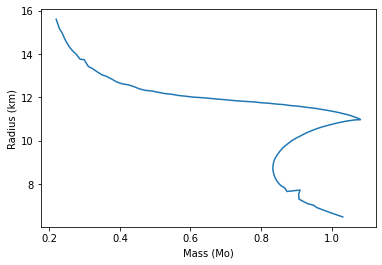

In [108]:
plt.plot(MRL_curve[:,0], MRL_curve[:,1])
plt.xlabel("Mass (Mo)")
plt.ylabel("Radius (km)")

In [113]:
ex_size = int(1e3)
EOS_size = ex_size + EOS_small.shape[0] - 1
MRL_size = 80
num = 10

EOS_tot = np.zeros((EOS_size, 3, num))
MRLs = np.zeros((MRL_size, 3, num))

for j in range(num):
    cs2 = np.ones(ns.shape[0]-1)

    begin_index = 5
    end_index = begin_index + j

    for i in range(cs2.shape[0]):
        if i < begin_index:
            cs2[i] = cs2_start

        elif begin_index <= i < end_index:
            cs2[i] = epsilon

    EOS_ex = extend_Plin(ns, starts, cs2, size=ex_size)
    EOS_tot[:,:,j] = stitch_EOS(EOS_small, EOS_ex)
    MRLs[:,:,j] = test_TOVsolver.solve(EOS_tot[:,:,j], max_pressure=1350, size=MRL_size)

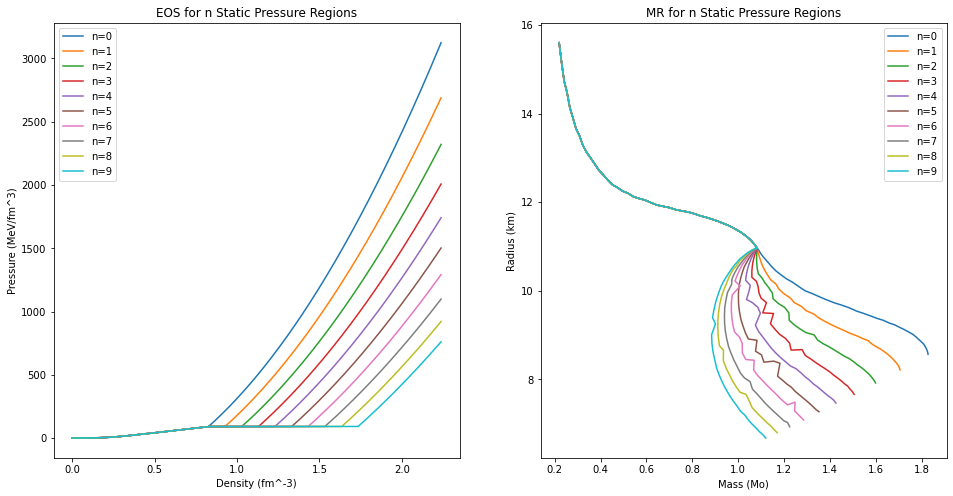

In [115]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

for i in range(num):
    ax[0].plot(EOS_tot[:,0,i], EOS_tot[:,1,i], label="n="+str(i))
    ax[0].set_xlabel("Density (fm^-3)")
    ax[0].set_ylabel("Pressure (MeV/fm^3)")
    ax[0].legend()
    ax[0].set_title("EOS for n Static Pressure Regions")
    
    ax[1].plot(MRLs[:,0,i], MRLs[:,1,i], label="n="+str(i))
    ax[1].set_xlabel("Mass (Mo)")
    ax[1].set_ylabel("Radius (km)")
    ax[1].legend()
    ax[1].set_title("MR for n Static Pressure Regions")